In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['potential_energy.csv', 'mulliken_charges.csv', 'train.csv', 'scalar_coupling_contributions.csv', 'sample_submission.csv', 'structures', 'test.csv', 'magnetic_shielding_tensors.csv', 'dipole_moments.csv', 'structures.csv']


In [2]:
!conda install -y -c rdkit rdkit;
from rdkit import Chem
!conda install -y -c openbabel openbabel;
#import openbabel as ob
#import pybel as pb

Solving environment: | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    rdkit-2018.09.1.0          |   py36h71b666b_1        20.2 MB  rdkit
    ------------------------------------------------------------
                                           Total:        20.2 MB

The following NEW packages will be INSTALLED:

  rdkit              rdkit/linux-64::rdkit-2018.09.1.0-py36h71b666b_1



rdkit-2018.09.1.0    | 20.2 MB   | ##################################### | 100% 
Preparing transaction: - done
Verifying transaction:

In [3]:
# import data
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
#structures = pd.read_csv("../input/structures.csv")

In [4]:
pd.DataFrame().to_csv('magic.csv',index=False)
import pybel as pb

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

We can extract features from the coupling type. See my previous kernel on [here](https://www.kaggle.com/edeanf/190621-predmolprop-exploration).

In [5]:
def PrintDataframe(df):
    print(df.to_string(),'\n')
    
def DecomposeType(df):
    df['num_bonds'] = df.type.map(lambda s: int(s[0]))
    df['atom_end_type'] = df.type.map(lambda s: s[-1])

DecomposeType(train)
DecomposeType(test)
PrintDataframe(train.head())

   id     molecule_name  atom_index_0  atom_index_1  type  scalar_coupling_constant  num_bonds atom_end_type
0   0  dsgdb9nsd_000001             1             0  1JHC                   84.8076          1             C
1   1  dsgdb9nsd_000001             1             2  2JHH                  -11.2570          2             H
2   2  dsgdb9nsd_000001             1             3  2JHH                  -11.2548          2             H
3   3  dsgdb9nsd_000001             1             4  2JHH                  -11.2543          2             H
4   4  dsgdb9nsd_000001             2             0  1JHC                   84.8074          1             C 



Although there are some features that can be extracted from the structures.csv, using the .xyz files is more powerful. I tried using the following api from jensengroup [github](https://github.com/jensengroup/xyz2mol) in order to import .xyz files into RDkit's Mol object, but there are errors. Jensen also [mentions](https://proteinsandwavefunctions.blogspot.com/2018/01/xyz2mol-converting-xyz-file-to-rdkit.html) that one can use openbabel to convert to smile and then convert to rdkit Mol object, but the ordering of the atoms can change, which is bad since we need to be able to reference in original indexing. So I wrote my own code which uses open babel

In [6]:
from collections import Counter

def ProcessXYZ(filepath):
    '''
    reads a filepath and returns RDKit Mol Object, 3D Distance Matrix, and Adjacency Matrix
    '''
    
    # load as openbabel molecule
    pbMol = pb.readfile("xyz", filepath).__next__()
    #obMol = pbMol.OBMol
    num_atoms = len(pbMol.atoms)#obMol.NumAtoms()
    
    # extract atomic properties
    rwMol = Chem.RWMol()
    conf = Chem.Conformer(num_atoms)
    AtomCounts = Counter()
    HybOrb = []
    atoms =[]
    PCList = []
    atom_coord = []
    atom_spins = []
    atom_valence = []
    atom_fc = []
    for i,atom in enumerate(pbMol.atoms):#ob.OBMolAtomIter(obMol):
        rwMol.AddAtom(Chem.Atom(atom.atomicnum))
        conf.SetAtomPosition(i, atom.coords)
        atom_coord.append(np.array(atom.coords))
        AtomCounts = AtomCounts+Counter(atom.type)
        atoms.append(atom.type)
        HybOrb.append(int(atom.hyb))
        PCList.append(atom.partialcharge)
        atom_spins.append(int(atom.spin))
        atom_valence.append(int(atom.valence))
        atom_fc.append(atom.formalcharge)
    # make RDKit Mol Object
    mol = rwMol.GetMol()
    mol.AddConformer(conf)
    
    # Get 3D Distance Matrix
    DistMat = np.array(Chem.Get3DDistanceMatrix(mol))
    
    # Now make adjacency matrix
    # note that Atom.GetIdx() appears to use one-based indexing
    AdjMat = np.zeros((num_atoms, num_atoms)).astype(int)
    
    def PBMolBondIter(pbMol):
        for i in range(pbMol.OBMol.NumBonds()):
            yield pbMol.OBMol.GetBond(i)
    
    for bond in PBMolBondIter(pbMol):#ob.OBMolBondIter(obMol):
        i,j = bond.GetBeginAtomIdx()-1, bond.GetEndAtomIdx()-1
        BO = bond.GetBO()
        AdjMat[i][j]=BO
        AdjMat[j][i]=BO
    return DistMat, AdjMat, atoms, HybOrb, pbMol.OBMol.NumBonds(),PCList, atom_coord, atom_spins, atom_valence, atom_fc

Because a single molecule is used multiple times, it is more straightforward if not more efficienct to iterate through the Dataframe instead of using assign. I imagine the efficiency depends on how expensive it is to load the .xyz file repeatedly and how much space it would take to store all the molecules in memory. In any case, we can optimize code later. Let's just get it to work.

In [7]:
def unit_vector(vector):
    """ Returns the unit vector of the vector """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2' """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)) * 180/np.pi

def angle_2bond(atom1,atom2,atom3):
    vect12 = atom1-atom2
    vect32 = atom3-atom2
    return angle_between(vect32,vect12)

def dihedral_angle(atom1, atom2, atom3, atom4):
    """
    Returns the dihedral angle between atoms 1 and 4
    given the x, y, z coordinates of all four atoms
    """
    # First calculate the vectors between different atom combinations
    vec_12 = atom1-atom2
    vec_23 = atom2-atom3
    vec_34 = atom3-atom4

    # Then calculate the normal vector for the plane that contains bonds 2-3 and 3-4
    norm = np.cross(vec_23, vec_34)

    # Now calculate the angle between the normal vector and vec_12
    # Subtract 90 deg to get the angle between the plane and vec_12
    return  angle_between(vec_12,norm) - 90


# Dictionary of distance features for each atom
def GetFeatureDict(DistMat,atoms):
    feature_dict ={}
    temp=DistMat[np.nonzero(DistMat)]
    feature_dict['min']=temp.min()
    feature_dict['mean']=temp.mean()
    feature_dict['max']=temp.max()
    temp=DistMat[np.nonzero(DistMat*[atom[0]=='C' for atom in atoms])]
    if temp.size>0:
        feature_dict['Cmin']=temp.min()
        feature_dict['Cmean']=temp.mean()
        feature_dict['Cmax']=temp.max()
    else:
        feature_dict['Cmin']=-1
        feature_dict['Cmean']=-1
        feature_dict['Cmax']=-1
    temp=DistMat[np.nonzero(DistMat*[atom[0]=='O' for atom in atoms])]
    if temp.size>0:
        feature_dict['Omin']=temp.min()
        feature_dict['Omean']=temp.mean()
        feature_dict['Omax']=temp.max()
    else:
        feature_dict['Omin']=-1
        feature_dict['Omean']=-1
        feature_dict['Omax']=-1
    temp=DistMat[np.nonzero(DistMat*[atom[0]=='N' for atom in atoms])]
    if temp.size>0:
        feature_dict['Nmin']=temp.min()
        feature_dict['Nmean']=temp.mean()
        feature_dict['Nmax']=temp.max()
    else:
        feature_dict['Nmin']=-1
        feature_dict['Nmean']=-1
        feature_dict['Nmax']=-1
    temp=DistMat[np.nonzero(DistMat*[atom[0]=='F' for atom in atoms])]
    if temp.size>0:
        feature_dict['Fmin']=temp.min()
        feature_dict['Fmean']=temp.mean()
        feature_dict['Fmax']=temp.max()
    else:
        feature_dict['Fmin']=-1
        feature_dict['Fmean']=-1
        feature_dict['Fmax']=-1
    return feature_dict

In [8]:
import scipy.sparse as sparse
def ExtendDataframe(df):
    # initialize the columns
    num_mol_bonds =[]
    min_d = []
    mean_d = []
    max_d = []
    space_dr=[]
    bond_dr=[]
    bond_1=[]
    bond_2=[]
    bond_3=[]
    
    atom_0_pc=[]
    atom_end_pc=[]
    atom_0_fc=[]
    atom_end_fc=[]
    atom_0_val=[]
    atom_end_val=[]
    atom_0_sm=[]
    atom_end_sm=[]
    
    atom_0_type2=[]
    atom_2_type=[]
    atom_3_type=[]
    atom_end_type2=[]
    atom_2_hyb=[]
    atom_3_hyb=[]
    atom_end_hyb=[]
    path_count = []
    
    atom_0_min = []
    atom_0_mean = []
    atom_0_max = []
    atom_0_Cmin = []
    atom_0_Cmean = []
    atom_0_Cmax = []
    atom_0_Omin = []
    atom_0_Omean = []
    atom_0_Omax = []
    atom_0_Nmin = []
    atom_0_Nmean = []
    atom_0_Nmax = []
    atom_0_Fmin = []
    atom_0_Fmean = []
    atom_0_Fmax = []

    atom_end_min = []
    atom_end_mean = []
    atom_end_max = []
    atom_end_Cmin = []
    atom_end_Cmean = []
    atom_end_Cmax = []
    atom_end_Omin = []
    atom_end_Omean = []
    atom_end_Omax = []
    atom_end_Nmin = []
    atom_end_Nmean = []
    atom_end_Nmax = []
    atom_end_Fmin = []
    atom_end_Fmean = []
    atom_end_Fmax = []

    bond2_angle = []
    bond3_angle = []
    
    # initialize the molecule currently loaded
    loaded_name = ''
    
    # Depth First Search for looking up bonds between atom_0 and atom_1
    def DFS(path):
        # a path is a list of atom indices starting from atom_0 which is at index i
        # only if the (num_bonds+1)th atom has index j is the path saved into paths
        # where j is the index of atom_1
        m = path[-1]
        if len(path) == num_bonds+1:
            if m == j:
                paths.append(path.copy())
        else:
            for _,n in zip(*SparseAdjMat[m].nonzero()):
                if n not in path:
                    path.append(n)
                    DFS(path)
                    path.pop()
    
    for row in df.itertuples(index=False):
        mol_name = row.molecule_name
        i = row.atom_index_0
        j = row.atom_index_1
        num_bonds = row.num_bonds
        
        # construct molecule properties
        if loaded_name != mol_name:
            # load new molecule
            loaded_name = mol_name
            filepath = '../input/structures/'+loaded_name+'.xyz'
            #mol,DistMat,AdjMat,AtomCounts,NumAtoms,atoms,HybOrb = ProcessXYZ(filepath)
            DistMat,AdjMat,atoms,HybOrb,bond_count,PCList,atom_coord,atom_spins, atom_val, atom_fc = ProcessXYZ(filepath)
            SparseAdjMat=sparse.csr_matrix(AdjMat)
            
            num_mol_bonds.append(bond_count)
            min_d.append(DistMat[np.nonzero(DistMat)].min())
            mean_d.append(DistMat[np.nonzero(DistMat)].mean())
            max_d.append(DistMat.max())
            atom_dist_dict={}
        else:
            num_mol_bonds.append(num_mol_bonds[-1])
            min_d.append(min_d[-1])
            mean_d.append(mean_d[-1])
            max_d.append(max_d[-1])
        
        # through-space distance and atom properties
        space_dr.append(DistMat[i][j])
        atom_0_type2.append(atoms[i])
        atom_end_type2.append(atoms[j])
        atom_0_pc.append(PCList[i])
        atom_end_pc.append(PCList[j])
        
        atom_0_fc.append(atom_fc[i])
        atom_end_fc.append(atom_fc[j])
        atom_0_val.append(atom_val[i])
        atom_end_val.append(atom_val[j])
        atom_0_sm.append(atom_spins[i])
        atom_end_sm.append(atom_spins[j])
        
        # find path between the atom_0 and atom_1
        paths = []
        if num_bonds>1:
            DFS([i])
            path_count.append(len(paths))
        
        if num_bonds==1:
            bond_dr.append(DistMat[i][j])
            bond_1.append(AdjMat[i][j])
            bond_2.append(-1)
            bond_3.append(-1)
            atom_2_type.append('')
            atom_3_type.append('')
            atom_2_hyb.append(-1)
            atom_3_hyb.append(-1)
            atom_end_hyb.append(HybOrb[j])
            path_count.append(1)
            bond2_angle.append(-1)
            bond3_angle.append(-1)
        elif num_bonds==2:
            path = paths[0]
            bond_dr.append(DistMat[path[0]][path[1]]+DistMat[path[1]][path[2]])
            bond_1.append(AdjMat[path[0]][path[1]])
            bond_2.append(AdjMat[path[1]][path[2]])
            bond_3.append(-1)
            atom_2_type.append(atoms[path[1]])
            atom_3_type.append('')
            atom_2_hyb.append(HybOrb[path[1]])
            atom_3_hyb.append(-1)
            atom_end_hyb.append(HybOrb[j])
            bond2_angle.append(abs(angle_2bond(atom_coord[path[0]],atom_coord[path[1]],atom_coord[path[2]])))
            bond3_angle.append(-1)
        else:
            path = paths[0]
            bond_dr.append(DistMat[path[0]][path[1]]+DistMat[path[1]][path[2]]+DistMat[path[2]][path[3]])
            bond_1.append(AdjMat[path[0]][path[1]])
            bond_2.append(AdjMat[path[1]][path[2]])
            bond_3.append(AdjMat[path[2]][path[3]])
            atom_2_type.append(atoms[path[1]])
            atom_3_type.append(atoms[path[2]])
            atom_2_hyb.append(HybOrb[path[1]])
            atom_3_hyb.append(HybOrb[path[2]])
            atom_end_hyb.append(HybOrb[j])
            bond2_angle.append(-1)
            bond3_angle.append(float(abs(dihedral_angle(atom_coord[path[0]],atom_coord[path[1]],atom_coord[path[2]],atom_coord[path[3]]))))
        
        # distance features for atom end
        if(i not in atom_dist_dict):
            atom_dist_dict[i]=GetFeatureDict(DistMat[i][:],atoms)
        feature_list = [
            ('min',atom_0_min),('mean',atom_0_mean),('max',atom_0_max),
            ('Cmin',atom_0_Cmin),('Cmean',atom_0_Cmean),('Cmax',atom_0_Cmax),
            ('Omin',atom_0_Omin),('Omean',atom_0_Omean),('Omax',atom_0_Omax),
            ('Nmin',atom_0_Nmin),('Nmean',atom_0_Nmean),('Nmax',atom_0_Nmax),
            ('Fmin',atom_0_Fmin),('Fmean',atom_0_Fmean),('Fmax',atom_0_Fmax)
        ]
        for name, feature in feature_list:
            feature.append(atom_dist_dict[i][name])
        
        if(j not in atom_dist_dict):
            atom_dist_dict[j]=GetFeatureDict(DistMat[j][:],atoms)    
        feature_list = [
            ('min',atom_end_min),('mean',atom_end_mean),('max',atom_end_max),
            ('Cmin',atom_end_Cmin),('Cmean',atom_end_Cmean),('Cmax',atom_end_Cmax),
            ('Omin',atom_end_Omin),('Omean',atom_end_Omean),('Omax',atom_end_Omax),
            ('Nmin',atom_end_Nmin),('Nmean',atom_end_Nmean),('Nmax',atom_end_Nmax),
            ('Fmin',atom_end_Fmin),('Fmean',atom_end_Fmean),('Fmax',atom_end_Fmax)
        ]
        for name, feature in feature_list:
            feature.append(atom_dist_dict[j][name])
        
    cols = {'num_mol_bonds': num_mol_bonds,
            'min_d':min_d,
            'mean_d':mean_d,
            'max_d':max_d,
            'space_dr': space_dr,
            'bond_dr': bond_dr,
            'bond_1': bond_1,
            'bond_2': bond_2,
            'bond_3': bond_3,
            'atom_0_pc': atom_0_pc,
            'atom_end_pc': atom_end_pc,
            'atom_0_fc': atom_0_fc,
            'atom_end_fc': atom_end_fc,
            'atom_0_val': atom_0_val,
            'atom_end_val': atom_end_val,
            'atom_0_sm': atom_0_sm,
            'atom_end_sm':atom_end_sm,
            'atom_0_type2': atom_0_type2,
            'atom_2_type': atom_2_type,
            'atom_3_type': atom_3_type,
            'atom_end_type2': atom_end_type2,
            'atom_2_hyb': atom_2_hyb,
            'atom_3_hyb': atom_3_hyb,
            'atom_end_hyb': atom_end_hyb,
            'path_count': path_count,
            'atom_0_min': atom_0_min,
            'atom_0_mean': atom_0_mean,
            'atom_0_max': atom_0_max,
            'atom_0_Cmin': atom_0_Cmin,
            'atom_0_Cmean': atom_0_Cmean,
            'atom_0_Cmax': atom_0_Cmax,
            'atom_0_Omin': atom_0_Omin,
            'atom_0_Omean': atom_0_Omean,
            'atom_0_Omax': atom_0_Omax,
            'atom_0_Nmin': atom_0_Nmin,
            'atom_0_Nmean': atom_0_Nmean,
            'atom_0_Nmax': atom_0_Nmax,
            'atom_0_Fmin': atom_0_Fmin,
            'atom_0_Fmean': atom_0_Fmean,
            'atom_0_Fmax': atom_0_Fmax,
            'atom_end_min': atom_end_min,
            'atom_end_mean': atom_end_mean,
            'atom_end_max': atom_end_max,
            'atom_end_Cmin': atom_end_Cmin,
            'atom_end_Cmean': atom_end_Cmean,
            'atom_end_Cmax': atom_end_Cmax,
            'atom_end_Omin': atom_end_Omin,
            'atom_end_Omean': atom_end_Omean,
            'atom_end_Omax': atom_end_Omax,
            'atom_end_Nmin': atom_end_Nmin,
            'atom_end_Nmean': atom_end_Nmean,
            'atom_end_Nmax': atom_end_Nmax,
            'atom_end_Fmin': atom_end_Fmin,
            'atom_end_Fmean': atom_end_Fmean,
            'atom_end_Fmax': atom_end_Fmax,
            'bond2_angle': bond2_angle,
            'bond3_angle': bond3_angle
            }
    return df.assign(**cols)

In [9]:
#train_sample = train.sample(10000)
import time
start = time.time()
#train_extend = ExtendDataframe(train_sample)
train_extend = ExtendDataframe(train)
test_extend = ExtendDataframe(test)
end = time.time()
print((end-start)/60)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


102.26250709692637


In [10]:
train_extend.columns

Index(['id', 'molecule_name', 'atom_index_0', 'atom_index_1', 'type',
       'scalar_coupling_constant', 'num_bonds', 'atom_end_type',
       'num_mol_bonds', 'min_d', 'mean_d', 'max_d', 'space_dr', 'bond_dr',
       'bond_1', 'bond_2', 'bond_3', 'atom_0_pc', 'atom_end_pc', 'atom_0_fc',
       'atom_end_fc', 'atom_0_val', 'atom_end_val', 'atom_0_sm', 'atom_end_sm',
       'atom_0_type2', 'atom_2_type', 'atom_3_type', 'atom_end_type2',
       'atom_2_hyb', 'atom_3_hyb', 'atom_end_hyb', 'path_count', 'atom_0_min',
       'atom_0_mean', 'atom_0_max', 'atom_0_Cmin', 'atom_0_Cmean',
       'atom_0_Cmax', 'atom_0_Omin', 'atom_0_Omean', 'atom_0_Omax',
       'atom_0_Nmin', 'atom_0_Nmean', 'atom_0_Nmax', 'atom_0_Fmin',
       'atom_0_Fmean', 'atom_0_Fmax', 'atom_end_min', 'atom_end_mean',
       'atom_end_max', 'atom_end_Cmin', 'atom_end_Cmean', 'atom_end_Cmax',
       'atom_end_Omin', 'atom_end_Omean', 'atom_end_Omax', 'atom_end_Nmin',
       'atom_end_Nmean', 'atom_end_Nmax', 'atom_end_Fmin'

In [11]:
train_extend.atom_0_type2.unique()

array(['H', 'HO'], dtype=object)

In [12]:
train_extend.atom_end_type2.unique()

array(['C3', 'H', 'N3', 'HO', 'C1', 'N1', 'C2', 'Nam', 'N2', 'Nar', 'Car',
       'Nox', 'Npl', 'N3+', 'Cac', 'C+', 'Ng+', 'Ntr'], dtype=object)

In [13]:
train_extend[train_extend.columns[:20]].describe()

,id,atom_index_0,atom_index_1,scalar_coupling_constant,num_bonds,num_mol_bonds,min_d,mean_d,max_d,space_dr,bond_dr,bond_1,bond_2,bond_3,atom_0_pc,atom_end_pc,atom_0_fc
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4658147.0,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4658147.0
mean,2.329073e+06,1.335689e+01,5.883966e+00,1.592165e+01,2.325156e+00,1.975888e+01,1.029168e+00,3.255689e+00,6.589293e+00,2.360922e+00,2.987136e+00,1.0,7.078817e-01,6.478327e-03,5.058974e-02,1.225711e-02,0.0
std,1.344691e+06,3.267712e+00,4.993943e+00,3.494198e+01,7.366406e-01,2.875716e+00,5.350769e-02,2.638297e-01,9.869911e-01,7.367096e-01,1.083377e+00,0.0,7.746804e-01,1.053283e+00,4.177597e-02,1.057742e-01,0.0
min,0.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01,1.000000e+00,2.000000e+00,9.586066e-01,1.145857e+00,1.513358e+00,1.002241e+00,1.002241e+00,1.0,-1.000000e+00,-1.000000e+00,-9.007463e-02,-4.188789e-01,0.0
25%,1.164536e+06,1.100000e+01,2.000000e+00,-2.549780e-01,2.000000e+00,1.800000e+01,9.646925e-01,3.080365e+00,5.868474e+00,1.948526e+00,2.363860e+00,1.0,1.000000e+00,-1.000000e+00,2.721544e-02,-3.294718e-02,0.0
50%,2.329073e+06,1.300000e+01,5.000000e+00,2.281130e+00,2.000000e+00,2.000000e+01,1.018438e+00,3.222618e+00,6.450707e+00,2.313485e+00,2.657140e+00,1.0,1.000000e+00,-1.000000e+00,3.420534e-02,2.626475e-02,0.0
75%,3.493610e+06,1.600000e+01,8.000000e+00,7.390655e+00,3.000000e+00,2.200000e+01,1.084557e+00,3.390371e+00,7.113688e+00,2.946476e+00,4.041835e+00,1.0,1.000000e+00,1.000000e+00,5.753240e-02,6.224376e-02,0.0
max,4.658146e+06,2.800000e+01,2.800000e+01,2.048800e+02,3.000000e+00,2.800000e+01,1.111452e+00,5.345653e+00,1.204039e+01,3.924354e+00,4.448899e+00,1.0,3.000000e+00,3.000000e+00,3.640839e-01,5.500642e-01,0.0


In [14]:
train_extend[train_extend.columns[6:21]].describe()

,num_bonds,num_mol_bonds,min_d,mean_d,max_d,space_dr,bond_dr,bond_1,bond_2,bond_3,atom_0_pc,atom_end_pc,atom_0_fc,atom_end_fc
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4658147.0,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4658147.0,4658147.0
mean,2.325156e+00,1.975888e+01,1.029168e+00,3.255689e+00,6.589293e+00,2.360922e+00,2.987136e+00,1.0,7.078817e-01,6.478327e-03,5.058974e-02,1.225711e-02,0.0,0.0
std,7.366406e-01,2.875716e+00,5.350769e-02,2.638297e-01,9.869911e-01,7.367096e-01,1.083377e+00,0.0,7.746804e-01,1.053283e+00,4.177597e-02,1.057742e-01,0.0,0.0
min,1.000000e+00,2.000000e+00,9.586066e-01,1.145857e+00,1.513358e+00,1.002241e+00,1.002241e+00,1.0,-1.000000e+00,-1.000000e+00,-9.007463e-02,-4.188789e-01,0.0,0.0
25%,2.000000e+00,1.800000e+01,9.646925e-01,3.080365e+00,5.868474e+00,1.948526e+00,2.363860e+00,1.0,1.000000e+00,-1.000000e+00,2.721544e-02,-3.294718e-02,0.0,0.0
50%,2.000000e+00,2.000000e+01,1.018438e+00,3.222618e+00,6.450707e+00,2.313485e+00,2.657140e+00,1.0,1.000000e+00,-1.000000e+00,3.420534e-02,2.626475e-02,0.0,0.0
75%,3.000000e+00,2.200000e+01,1.084557e+00,3.390371e+00,7.113688e+00,2.946476e+00,4.041835e+00,1.0,1.000000e+00,1.000000e+00,5.753240e-02,6.224376e-02,0.0,0.0
max,3.000000e+00,2.800000e+01,1.111452e+00,5.345653e+00,1.204039e+01,3.924354e+00,4.448899e+00,1.0,3.000000e+00,3.000000e+00,3.640839e-01,5.500642e-01,0.0,0.0


In [15]:
train_extend[train_extend.columns[21:36]].describe()

,atom_0_val,atom_end_val,atom_0_sm,atom_end_sm,atom_2_hyb,atom_3_hyb,atom_end_hyb,path_count,atom_0_min,atom_0_mean,atom_0_max
count,4658147.0,4.658147e+06,4658147.0,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,1.0,3.121726e+00,0.0,1.211061e-02,2.271297e+00,8.566037e-01,2.174139e+00,1.034380e+00,1.086151e+00,3.448149e+00,5.583775e+00
std,0.0,1.202994e+00,0.0,1.551868e-01,1.464550e+00,1.929500e+00,1.201639e+00,1.895493e-01,2.592215e-02,4.241759e-01,9.728497e-01
min,1.0,1.000000e+00,0.0,0.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,1.000000e+00,9.586066e-01,1.237732e+00,1.513358e+00
25%,1.0,2.000000e+00,0.0,0.000000e+00,3.000000e+00,-1.000000e+00,2.000000e+00,1.000000e+00,1.087620e+00,3.153603e+00,4.921539e+00
50%,1.0,4.000000e+00,0.0,0.000000e+00,3.000000e+00,-1.000000e+00,3.000000e+00,1.000000e+00,1.093561e+00,3.370020e+00,5.422875e+00
75%,1.0,4.000000e+00,0.0,0.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,1.000000e+00,1.095879e+00,3.651209e+00,6.146281e+00
max,1.0,4.000000e+00,0.0,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,1.247942e+00,7.585518e+00,1.204039e+01


In [16]:
train_extend.atom_end_sm.unique()

array([0, 2, 3])

In [17]:
train_extend[train_extend.columns[36:51]].describe()

,atom_0_Cmin,atom_0_Cmean,atom_0_Cmax,atom_0_Omin,atom_0_Omean,atom_0_Omax,atom_0_Nmin,atom_0_Nmean,atom_0_Nmax,atom_0_Fmin,atom_0_Fmean,atom_0_Fmax,atom_end_min,atom_end_mean,atom_end_max
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,1.156816e+00,3.000913e+00,4.603247e+00,2.495728e+00,2.802087e+00,3.110704e+00,1.207891e+00,1.398023e+00,1.582726e+00,-9.686235e-01,-9.673718e-01,-9.660134e-01,1.142591e+00,2.954799e+00,4.936891e+00
std,2.367558e-01,4.678379e-01,9.935855e-01,1.947983e+00,2.017329e+00,2.213152e+00,2.218438e+00,2.346820e+00,2.548368e+00,4.059599e-01,4.197352e-01,4.363600e-01,1.209999e-01,4.779996e-01,1.056066e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,9.586066e-01,1.017195e+00,1.017208e+00
25%,1.090556e+00,2.674816e+00,3.956129e+00,2.055108e+00,2.333356e+00,2.457948e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.089709e+00,2.598649e+00,4.201412e+00
50%,1.094228e+00,2.913418e+00,4.454278e+00,2.718270e+00,3.267650e+00,3.601330e+00,1.021719e+00,2.114150e+00,2.132134e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.094119e+00,2.853414e+00,4.734151e+00
75%,1.096858e+00,3.232154e+00,5.184237e+00,3.801027e+00,4.079756e+00,4.540916e+00,3.039998e+00,3.403922e+00,3.815579e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.100299e+00,3.218238e+00,5.574344e+00
max,3.496963e+00,6.523529e+00,1.115916e+01,1.092534e+01,1.092534e+01,1.092534e+01,1.075381e+01,1.075381e+01,1.075381e+01,7.805846e+00,7.805846e+00,8.341639e+00,1.568057e+00,6.885714e+00,1.204039e+01


In [18]:
train_extend[train_extend.columns[51:]].describe()

,atom_end_Cmin,atom_end_Cmean,atom_end_Cmax,atom_end_Omin,atom_end_Omean,atom_end_Omax,atom_end_Nmin,atom_end_Nmean,atom_end_Nmax,atom_end_Fmin,atom_end_Fmean,atom_end_Fmax,bond2_angle,bond3_angle
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06,4.658145e+06
mean,1.432461e+00,2.623027e+00,3.946114e+00,2.049699e+00,2.336697e+00,2.625781e+00,8.592217e-01,9.994223e-01,1.140016e+00,-9.734739e-01,-9.726345e-01,-9.716668e-01,3.920982e+01,1.590149e+01
std,2.299194e-01,5.494215e-01,1.086306e+00,1.756172e+00,1.822792e+00,2.014773e+00,2.000306e+00,2.110014e+00,2.277231e+00,3.455363e-01,3.557526e-01,3.688438e-01,5.478522e+01,2.371231e+01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.336561e+00,2.215969e+00,3.151457e+00,1.401545e+00,1.765791e+00,2.035880e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
50%,1.501337e+00,2.528806e+00,3.803336e+00,2.388518e+00,2.628668e+00,2.974281e+00,1.157434e+00,1.331359e+00,1.349157e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
75%,1.529120e+00,2.927891e+00,4.601007e+00,3.151907e+00,3.484171e+00,3.915241e+00,2.468042e+00,2.694079e+00,3.136625e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.090582e+02,3.455320e+01
max,3.976531e+00,6.523529e+00,1.115916e+01,1.047548e+01,1.047548e+01,1.066189e+01,1.075367e+01,1.075367e+01,1.075367e+01,7.326080e+00,7.511074e+00,7.817624e+00,1.800000e+02,8.204611e+01


In [19]:
import seaborn as sns

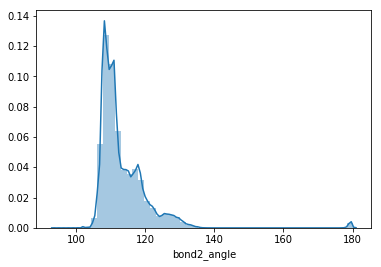

In [20]:
sns.distplot(train_extend[train_extend.bond2_angle!=-1].bond2_angle)

ValueError: cannot convert float NaN to integer

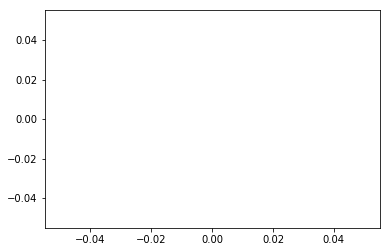

In [21]:
sns.distplot(train_extend[train_extend.bond3_angle!=-1].bond3_angle)

In [22]:
# save for model building
train_extend.to_csv('train_extend.csv', index=False)
test_extend.to_csv('test_extend.csv', index=False)